In [4]:
import numpy as np
import pandas as pd
import os
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

from glob import glob
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

warnings.filterwarnings("ignore")

In [5]:
file_path = "merged_CICIDS2017.csv"
data = pd.read_csv(file_path)

In [6]:
# Display basic dataset information
print("Original Dataset shape:", data.shape)

Original Dataset shape: (2830743, 79)


In [7]:
# Handle Missing Values
missing_values = data.isnull().sum()
print("Missing values per column:\n\n", missing_values)

# Fill missing values with the median for numerical columns
data = data.fillna(data.median())

# Remove duplicates
data = data.drop_duplicates()
print("Dataset shape after removing duplicates:", data.shape)

# Inspect column names to identify the correct target column
print("Column names in the dataset:", data.columns)

# Strip any leading/trailing spaces from column names
data.columns = data.columns.str.strip()

# Set the correct target column name
target_column = "Label"

# Encode target labels
label_encoder = LabelEncoder()
data[target_column] = label_encoder.fit_transform(data[target_column])


Missing values per column:

  Destination Port              0
 Flow Duration                 0
 Total Fwd Packets             0
 Total Backward Packets        0
Total Length of Fwd Packets    0
                              ..
Idle Mean                      0
 Idle Std                      0
 Idle Max                      0
 Idle Min                      0
 Label                         0
Length: 79, dtype: int64
Dataset shape after removing duplicates: (2522362, 79)
Column names in the dataset: Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Ma

In [8]:
# Separate features and target
X = data.drop(columns=[target_column])  # Features
y = data[target_column]                # Target

In [9]:
# Check for infinity or very large values
print("Contains Inf values:", np.isinf(X).any().any())
print("Contains NaN values:", np.isnan(X).any().any())

Contains Inf values: True
Contains NaN values: False


In [10]:
# Replace infinite values with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with column mean (or median)
X.fillna(X.mean(), inplace=True)

In [11]:
print("Contains Inf values (after fix):", np.isinf(X).any().any())
print("Contains NaN values (after fix):", np.isnan(X).any().any())

Contains Inf values (after fix): False
Contains NaN values (after fix): False


In [ ]:
# Random Forest

Top 10 Features selected using PCC:
                   Feature  PCC_Score
22             Fwd IAT Std   0.299340
74               Idle Mean   0.278336
13   Bwd Packet Length Std   0.277795
76                Idle Max   0.277214
77                Idle Min   0.275874
23             Fwd IAT Max   0.274162
18            Flow IAT Max   0.273553
10   Bwd Packet Length Max   0.271567
12  Bwd Packet Length Mean   0.262230
54    Avg Bwd Segment Size   0.262230
Accuracy: 0.9689101094344061
Precision: 0.9723002179898705
Recall: 0.9689101094344061
F1 Score: 0.970222164756971


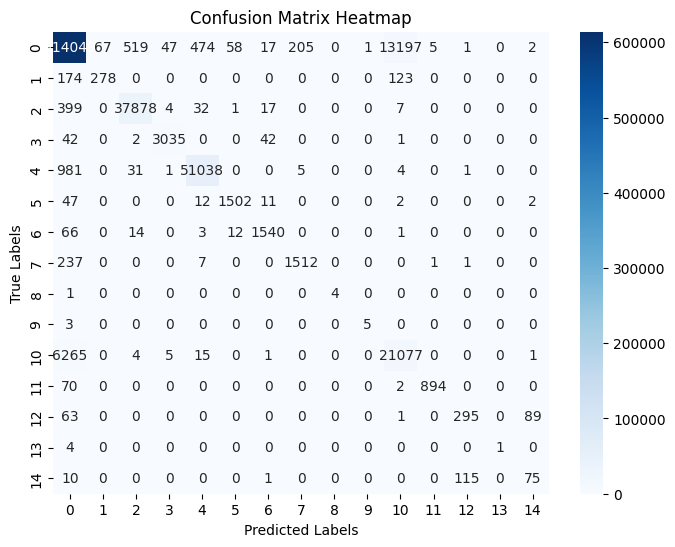

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

if y.dtypes == 'object':
    y_encoded = LabelEncoder().fit_transform(y)
else:
    y_encoded = y

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

# Calculate PCC for all features with respect to the target
pcc_scores = []
for col in X.columns:
    pcc = np.corrcoef(X[col], y_encoded)[0, 1]  # Pearson correlation coefficient
    pcc_scores.append(abs(pcc))  # Take absolute value for ranking

# Create a DataFrame to store feature names and their PCC scores
pcc_df = pd.DataFrame({
    'Feature': X.columns,
    'PCC_Score': pcc_scores
})

# Sort by PCC scores in descending order and select the top 10 features
top_10_pcc_features = pcc_df.sort_values(by='PCC_Score', ascending=False).head(10)
top_features = top_10_pcc_features['Feature'].tolist()

print("Top 10 Features selected using PCC:")
print(top_10_pcc_features)

# Select the top features for training and testing sets
X_train_selected_pcc = X_train[top_features]
X_test_selected_pcc = X_test[top_features]

# Train the Random Forest classifier
rf_classifier_pcc = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier_pcc.fit(X_train_selected_pcc, y_train)

# Predictions and evaluation metrics
y_pred = rf_classifier_pcc.predict(X_test_selected_pcc)

# Accuracy, Precision, Recall, F1 Score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)


# Display metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()


In [ ]:
# AdaBoost 

In [15]:
# Select the top features for training and testing sets
X_train_selected_pcc = X_train[top_features]
X_test_selected_pcc = X_test[top_features]

# Train the AdaBoost classifier
adaboost_classifier_pcc = AdaBoostClassifier(n_estimators=50, random_state=42)
adaboost_classifier_pcc.fit(X_train_selected_pcc, y_train)

# Predict and evaluate
y_pred_pcc = adaboost_classifier_pcc.predict(X_test_selected_pcc)
accuracy_pcc = accuracy_score(y_test, y_pred_pcc)
conf_matrix_pcc = confusion_matrix(y_test, y_pred_pcc)

# Output results
print("PCC Accuracy with AdaBoost:", accuracy_pcc)
print("PCC Confusion Matrix with AdaBoost:\n", conf_matrix_pcc)

PCC Accuracy with AdaBoost: 0.8592457602592278
PCC Confusion Matrix with AdaBoost:
 [[605683      0     11   6915      3      0      0      0      0      0
   15178      0      0    852      0]
 [   575      0      0      0      0      0      0      0      0      0
       0      0      0      0      0]
 [ 14061      0   1807   4925   2646      0      0      0      0      0
    2076      0      0  12823      0]
 [  1024      0    132   1563      0      0      0      0      0      0
     207      0      0    196      0]
 [  5494      0     21    475  41139      0      0      0      0      0
    1172      0      0   3760      0]
 [  1488      0      0      2      0      0      0      0      0      0
      13      0      0     73      0]
 [  1595      0      0      1      0      0      0      0      0      0
      22      0      0     18      0]
 [  1758      0      0      0      0      0      0      0      0      0
       0      0      0      0      0]
 [     5      0      0      0      0